In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Function to load frames from a video file
def loadFrame(videoPath: str, numberFrame: int) -> list:
    frameList = []
    videoCap = cv.VideoCapture(videoPath)
    count = 0
    while count < numberFrame:
        success, frame = videoCap.read()
        if not success:
            break
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frameList.append(frame)
        count += 1
    return frameList

In [5]:
# Function to show images in a grid
plt.figure(figsize=(6.0, 6.0), dpi=300)
plt_row = 4
plt_col = 3
def show(slot, img, title, cmap=None):
    plt.subplot(plt_row, plt_col, slot)
    if cmap is None:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)

<Figure size 1800x1800 with 0 Axes>

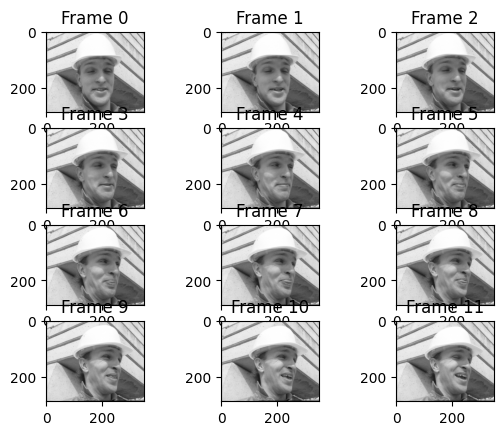

In [7]:
# Load frames
frms = loadFrame('foreman_cif.y4m', 12)

# Show original frames
for t in range(12):
    show(t+1, frms[t], f"Frame {t}", 'gray')

PSNR (Avg Frame 0) = 30.303657936216016
PSNR (Avg Frame 1) = 30.369387349251564
PSNR (Avg Frame 2) = 31.867327826641297
PSNR (Avg Frame 3) = 31.280883059541516
PSNR (Avg Frame 4) = 30.81885950084829


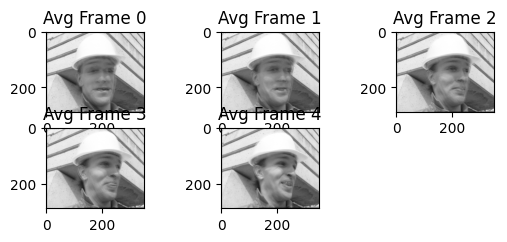

In [9]:
# Drop odd frames and keep even frames
even_frames = frms[::2]
odd_frames = frms[1::2]

# Interpolation using frame averaging
for i in range(len(even_frames) - 1):
    backward = even_frames[i]
    forward = even_frames[i + 1]
    ground = odd_frames[i]
    
    # Simple frame averaging
    average = (backward // 2) + (forward // 2)
    # Calculate PSNR
    psnr_avg = cv.PSNR(ground, average)
    show(i + 1, average, f"Avg Frame {i}", 'gray')
    print(f"PSNR (Avg Frame {i}) = {psnr_avg}")


In [11]:
# Motion compensation
BLOCK_SIZE = 16
SEARCH_RANGE = 8

def get_block(img, x, y, block_size):
    return img[y:y+block_size, x:x+block_size]

def mse(block1, block2):
    return np.mean((block1 - block2) ** 2)

def motion_compensation(backward, forward, block_size, search_range):
    height, width = backward.shape
    interpolated = np.zeros_like(backward)
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            min_mse = float('inf')
            best_match = (0, 0)
            
            for dy in range(-search_range, search_range + 1):
                for dx in range(-search_range, search_range + 1):
                    new_y = y + dy
                    new_x = x + dx
                    
                    if new_x < 0 or new_y < 0 or new_x + block_size > width or new_y + block_size > height:
                        continue
                    
                    block_backward = get_block(backward, x, y, block_size)
                    block_forward = get_block(forward, new_x, new_y, block_size)
                    
                    current_mse = mse(block_backward, block_forward)
                    
                    if current_mse < min_mse:
                        min_mse = current_mse
                        best_match = (new_x, new_y)
            
            x_match, y_match = best_match
            interpolated[y:y+block_size, x:x+block_size] = (
                get_block(backward, x, y, block_size) // 2 + get_block(forward, x_match, y_match, block_size) // 2
            )
    
    return interpolated


PSNR (MC Frame 0) = 26.971607891971196
PSNR (MC Frame 1) = 27.38498983419701
PSNR (MC Frame 2) = 28.486305089112243
PSNR (MC Frame 3) = 27.23097796096747
PSNR (MC Frame 4) = 26.181798098150132


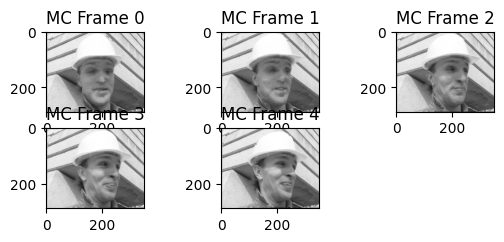

In [12]:
# Apply motion compensation and calculate PSNR
for i in range(len(even_frames) - 1):
    backward = even_frames[i]
    forward = even_frames[i + 1]
    ground = odd_frames[i]
    
    interpolated = motion_compensation(backward, forward, BLOCK_SIZE, SEARCH_RANGE)
    psnr_mc = cv.PSNR(ground, interpolated)
    
    show(i + 1 + len(even_frames), interpolated, f"MC Frame {i}", 'gray')
    print(f"PSNR (MC Frame {i}) = {psnr_mc}")

plt.show()
